In [1]:
import os
import numpy as np
import torch
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRanged, SpatialPadd, RandCropByLabelClassesd, Lambdad, ToTensord
)
from tqdm import tqdm
import glob


In [2]:
def binarize_label(x):
    return (x == 1).astype(np.uint8)

In [3]:
data_dir = "D:/monai-project/asa/data"
image_files = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "liver_*.nii.gz")))
label_files = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "liver_*.nii.gz")))
save_dir = "D:/monai-project/asa/patches_nifti"
os.makedirs(save_dir, exist_ok=True)

In [4]:
crop_size = (128, 128, 64)
num_samples_per_volume = 8

In [5]:
preprocess = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1,1,3), mode=("bilinear", "nearest")),
    ScaleIntensityRanged(
        keys="image",
        a_min=-200, a_max=200,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    SpatialPadd(keys=["image", "label"], spatial_size=crop_size),
    Lambdad(keys="label", func=binarize_label),
    ToTensord(keys=["image", "label"]),
])


In [6]:
cropper = RandCropByLabelClassesd(
    keys=["image", "label"],
    label_key="label",
    spatial_size=crop_size,
    num_classes=2,
    num_samples=num_samples_per_volume,
)


In [ ]:
# patch_idx = 0
# for img_path, lbl_path in tqdm(zip(image_files, label_files), total=len(image_files)):
#     data = preprocess({"image": img_path, "label": lbl_path})
#     cropped = cropper(data)
#     for i, patch in enumerate(cropped):
#         img_patch = patch["image"].numpy()
#         lbl_patch = patch["label"].numpy()
#         # Skip empty patches (no liver)
#         if lbl_patch.sum() == 0:
#             continue
#         # Remove channel dimension for NIfTI (shape: 1, X, Y, Z) -> (X, Y, Z)
#         img_patch = np.squeeze(img_patch)
#         lbl_patch = np.squeeze(lbl_patch)
#         # Save as NIfTI
#         img_nii = nib.Nifti1Image(img_patch, affine=np.eye(4))
#         lbl_nii = nib.Nifti1Image(lbl_patch, affine=np.eye(4))
#         nib.save(img_nii, os.path.join(save_dir, f"patch_{patch_idx:05d}_img.nii.gz"))
#         nib.save(lbl_nii, os.path.join(save_dir, f"patch_{patch_idx:05d}_lbl.nii.gz"))
#         patch_idx += 1

# print(f"Saved {patch_idx} non-empty NIfTI patches to {save_dir}")

  0%|          | 0/131 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [9]:
import glob
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU
import matplotlib.pyplot as plt
import random

In [10]:
patch_dir = "D:/monai-project/asa/patches_nifti"
img_files = sorted(glob.glob(os.path.join(patch_dir, "*_img.nii.gz")))
lbl_files = sorted(glob.glob(os.path.join(patch_dir, "*_lbl.nii.gz")))



In [11]:
num_samples = len(img_files)
train_split = int(num_samples * 0.6)
val_split = int(num_samples * 0.75)

train_imgs = img_files[:train_split]
val_imgs = img_files[train_split:val_split]
test_imgs = img_files[val_split:]

train_lbls = lbl_files[:train_split]
val_lbls = lbl_files[train_split:val_split]
test_lbls = lbl_files[val_split:]

train_files = [{"image": i, "label": l} for i, l in zip(train_imgs, train_lbls)]
val_files = [{"image": i, "label": l} for i, l in zip(val_imgs, val_lbls)]
test_files = [{"image": i, "label": l} for i, l in zip(test_imgs, test_lbls)]

In [12]:
patch_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ToTensord(keys=["image", "label"]),
])


In [13]:
train_ds = Dataset(data=train_files, transform=patch_transforms)
val_ds = Dataset(data=val_files, transform=patch_transforms)
test_ds = Dataset(data=test_files, transform=patch_transforms)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=0)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [27]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
iou_metric = MeanIoU(include_background=True, reduction="mean", get_not_nans=False)

In [29]:
max_epochs = 50
train_losses = []
val_dice_scores = []
val_iou_scores = []
val_accuracies = []

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        batch_images = batch["image"].to(device)
        batch_labels = batch["label"].to(device)
        optimizer.zero_grad()
        # --- FIX: Squeeze channel if present ---
        if batch_labels.ndim == 5 and batch_labels.shape[1] == 1:
            batch_labels = batch_labels.squeeze(1)
        outputs = model(batch_images)
        labels_onehot = torch.nn.functional.one_hot(batch_labels.long(), num_classes=2)
        labels_onehot = labels_onehot.permute(0, 4, 1, 2, 3).float()
        loss = loss_function(outputs, labels_onehot)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    # --- Validation ---
    model.eval()
    dice_vals, iou_vals, acc_vals = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            val_images_batch = batch["image"].to(device)
            val_labels_batch = batch["label"].to(device)
            if val_labels_batch.ndim == 5 and val_labels_batch.shape[1] == 1:
                val_labels_batch = val_labels_batch.squeeze(1)
            val_labels_batch = val_labels_batch.long()  # <-- Ensure correct type
            val_outputs = model(val_images_batch)
            preds = torch.argmax(val_outputs, dim=1)
            correct = (preds == val_labels_batch).sum().item()
            total = torch.numel(val_labels_batch)
            acc_vals.append(correct / total)
            dice_metric(y_pred=val_outputs, y=val_labels_batch)
            iou_metric(y_pred=preds, y=val_labels_batch)
            dice_vals.append(dice_metric.aggregate().item())
            iou_vals.append(iou_metric.aggregate().item())
            dice_metric.reset()
            iou_metric.reset()
    avg_dice = np.mean(dice_vals)
    avg_iou = np.mean(iou_vals)
    avg_acc = np.mean(acc_vals)
    val_dice_scores.append(avg_dice)
    val_iou_scores.append(avg_iou)
    val_accuracies.append(avg_acc)

    print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {epoch_loss:.4f} | Val Dice: {avg_dice:.4f} | Val Jaccard: {avg_iou:.4f} | Val Acc: {avg_acc:.4f}")

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"checkpoint_patch_epoch{epoch+1}.pth")
        print(f"Checkpoint saved at epoch {epoch+1}")


Epoch 1/50 | Train Loss: 0.1779 | Val Dice: 0.2902 | Val Jaccard: 0.5059 | Val Acc: 0.8973
Epoch 2/50 | Train Loss: 0.1613 | Val Dice: 0.2902 | Val Jaccard: 0.6271 | Val Acc: 0.9406
Epoch 3/50 | Train Loss: 0.1421 | Val Dice: 0.2902 | Val Jaccard: 0.6257 | Val Acc: 0.9517
Epoch 4/50 | Train Loss: 0.1348 | Val Dice: 0.2902 | Val Jaccard: 0.6490 | Val Acc: 0.9565
Epoch 5/50 | Train Loss: 0.1253 | Val Dice: 0.2902 | Val Jaccard: 0.6597 | Val Acc: 0.9638
Epoch 6/50 | Train Loss: 0.1134 | Val Dice: 0.2902 | Val Jaccard: 0.6978 | Val Acc: 0.9662
Epoch 7/50 | Train Loss: 0.1056 | Val Dice: 0.2902 | Val Jaccard: 0.6781 | Val Acc: 0.9607
Epoch 8/50 | Train Loss: 0.1022 | Val Dice: 0.2902 | Val Jaccard: 0.6896 | Val Acc: 0.9623
Epoch 9/50 | Train Loss: 0.1018 | Val Dice: 0.2902 | Val Jaccard: 0.7056 | Val Acc: 0.9699
Epoch 10/50 | Train Loss: 0.0989 | Val Dice: 0.2902 | Val Jaccard: 0.5528 | Val Acc: 0.9452
Checkpoint saved at epoch 10
Epoch 11/50 | Train Loss: 0.0922 | Val Dice: 0.2902 | Val Ja

In [30]:
torch.save(model.state_dict(), "liver_seg_unet_2class_patch.pth")
print("Model saved as liver_seg_unet_2class_patch.pth")

Model saved as liver_seg_unet_2class_patch.pth


In [32]:
test_dice_scores = []
test_iou_scores = []
test_accuracies = []

model.eval()
dice_metric.reset()
iou_metric.reset()
with torch.no_grad():
    for batch in test_loader:
        test_images = batch["image"].to(device)
        test_labels = batch["label"].to(device)
        if test_labels.ndim == 5 and test_labels.shape[1] == 1:
            test_labels = test_labels.squeeze(1)
        test_labels = test_labels.long()
        test_outputs = model(test_images)
        preds = torch.argmax(test_outputs, dim=1)
        correct = (preds == test_labels).sum().item()
        total = torch.numel(test_labels)
        test_accuracies.append(correct / total)
        dice_metric(y_pred=test_outputs, y=test_labels)
        iou_metric(y_pred=preds, y=test_labels)
        test_dice_scores.append(dice_metric.aggregate().item())
        test_iou_scores.append(iou_metric.aggregate().item())
        dice_metric.reset()
        iou_metric.reset()

avg_test_dice = np.mean(test_dice_scores)
avg_test_iou = np.mean(test_iou_scores)
avg_test_acc = np.mean(test_accuracies)

print(f"Test Dice: {avg_test_dice:.4f} | Test Jaccard: {avg_test_iou:.4f} | Test Accuracy: {avg_test_acc:.4f}")

Test Dice: 0.2844 | Test Jaccard: 0.7437 | Test Accuracy: 0.9719


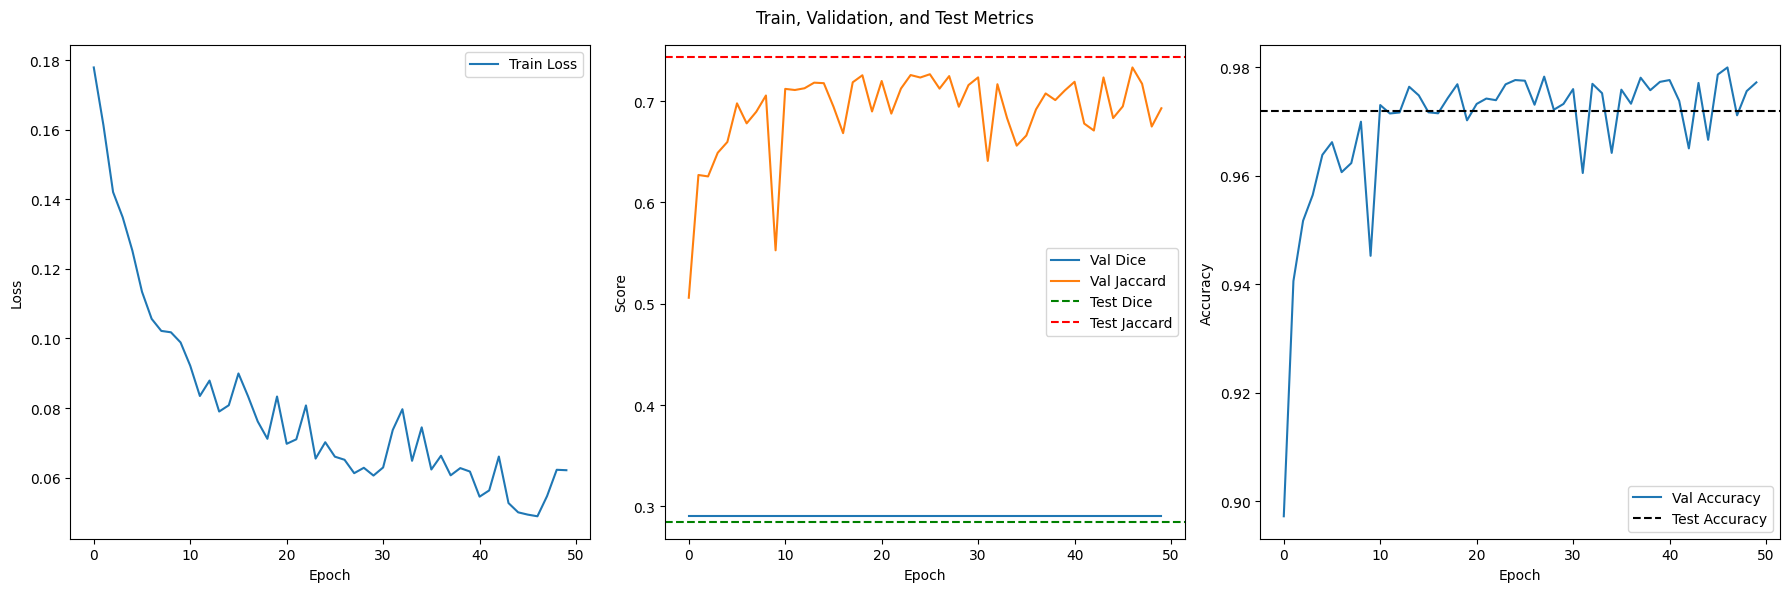

In [33]:
plt.figure(figsize=(18,6))

# Train Loss
plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Dice & Jaccard
plt.subplot(1,3,2)
plt.plot(val_dice_scores, label="Val Dice")
plt.plot(val_iou_scores, label="Val Jaccard")
plt.axhline(avg_test_dice, color='g', linestyle='--', label="Test Dice")
plt.axhline(avg_test_iou, color='r', linestyle='--', label="Test Jaccard")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

# Accuracy
plt.subplot(1,3,3)
plt.plot(val_accuracies, label="Val Accuracy")
plt.axhline(avg_test_acc, color='k', linestyle='--', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.suptitle("Train, Validation, and Test Metrics")
plt.tight_layout()
plt.savefig("train_val_test_metrics.png")
plt.show()

Liver detected in the NIfTI volume!


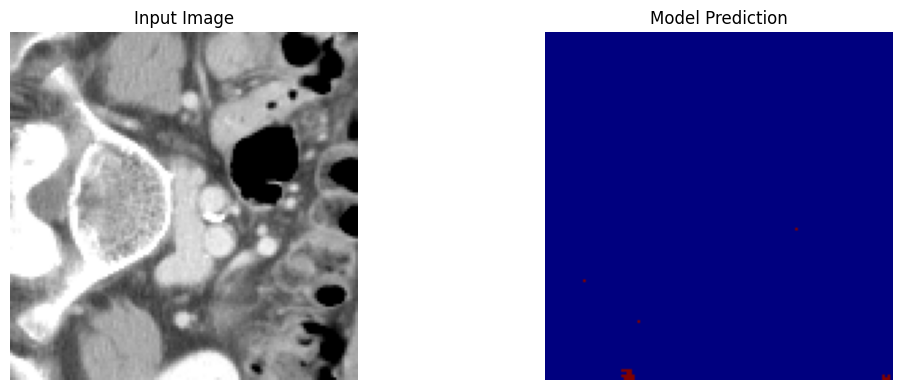

In [37]:
from monai.transforms import CenterSpatialCrop

nifti_path = "D:/monai-project/volume-0.nii"
crop_size = (128, 128, 64)  # Use your training crop size

test_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1,1,3), mode="bilinear"),
    ScaleIntensityRanged(
        keys="image",
        a_min=-200, a_max=200,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    SpatialPadd(keys=["image"], spatial_size=crop_size),
    ToTensord(keys=["image"]),
])

data = test_transforms({"image": nifti_path})
img = data["image"]

# Ensure input shape is (1, 128, 128, 64)
if img.shape != (1, 128, 128, 64):
    cropper = CenterSpatialCrop(roi_size=crop_size)
    img = cropper(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

model.eval()
with torch.no_grad():
    output = model(img)
    pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (128, 128, 64)

if np.any(pred == 1):
    print("Liver detected in the NIfTI volume!")
else:
    print("No liver detected in the NIfTI volume.")

# Visualize a middle slice
slice_idx = pred.shape[2] // 2
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
plt.title("Input Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(pred[:, :, slice_idx], cmap="jet", vmin=0, vmax=1)
plt.title("Model Prediction")
plt.axis("off")
plt.tight_layout()
plt.show()

Liver detected in the NIfTI volume!
Liver detected in slice 33


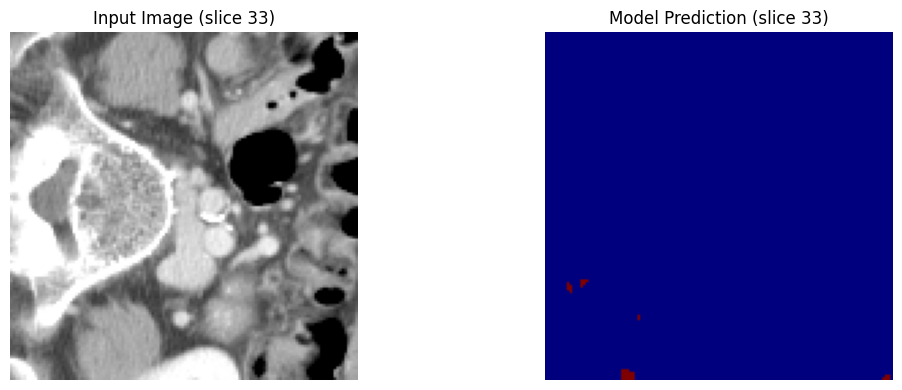

In [ ]:
from monai.transforms import CenterSpatialCrop

nifti_path = "D:/monai-project/volume-0.nii"
crop_size = (128, 128, 64)  # Use your training crop size

test_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1,1,3), mode="bilinear"),
    ScaleIntensityRanged(
        keys="image",
        a_min=-200, a_max=200,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    SpatialPadd(keys=["image"], spatial_size=crop_size),
    ToTensord(keys=["image"]),
])

data = test_transforms({"image": nifti_path})
img = data["image"]

# Ensure input shape is (1, 128, 128, 64)
if img.shape != (1, 128, 128, 64):
    cropper = CenterSpatialCrop(roi_size=crop_size)
    img = cropper(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

model.eval()
with torch.no_grad():
    output = model(img)
    pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (128, 128, 64)

if np.any(pred == 1):
    print("Liver detected in the NIfTI volume!")
    # Find all slices with liver
    liver_slices = np.where(np.any(pred == 1, axis=(0, 1)))[0]
    # Pick the middle slice with liver
    slice_idx = 45
    print(f"Liver detected in slice {slice_idx}")
else:
    print("No liver detected in the NIfTI volume.")
    slice_idx = pred.shape[2] // 2  # fallback to middle slice

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
plt.title(f"Input Image (slice {slice_idx})")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(pred[:, :, slice_idx], cmap="jet", vmin=0, vmax=1)
plt.title(f"Model Prediction (slice {slice_idx})")
plt.axis("off")
plt.tight_layout()
plt.show()